# Task 1: SMA Updated Version

# Step 1: Get Data

In [1]:
import tushare as ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.ticker as mtick

In [2]:
pro = ts.pro_api()

In [3]:
def get_index_daily(ts_code, start_date):
    '''
    To get specified index data and formalize it
    
    
    output: A dataframe corresponds to a data
    '''
    df = pro.index_daily(ts_code = ts_code, start_date = start_date, end_date = '')
    df['trade_date'] = pd.to_datetime(df['trade_date'].astype(str), format = '%Y-%m-%d')
    df.set_index('trade_date',inplace=True)
    return df.sort_index()

In [4]:
df_hs = get_index_daily(ts_code = '000300.SH', start_date = '20140930')

In [5]:
df_hs.head(5)

,ts_code,close,open,high,low,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2014-09-30,000300.SH,2450.988,2452.166,2454.885,2444.204,2447.799,3.189,0.1303,115804229.0,1.019066e+08
2014-10-08,000300.SH,2478.383,2460.870,2478.383,2445.268,2450.988,27.395,1.1177,121953604.0,1.165001e+08
2014-10-09,000300.SH,2481.955,2480.197,2488.113,2461.112,2478.383,3.572,0.1441,137923920.0,1.207526e+08
2014-10-10,000300.SH,2466.789,2472.096,2482.136,2457.684,2481.955,-15.166,-0.6111,147634307.0,1.219250e+08
2014-10-13,000300.SH,2454.946,2457.412,2460.389,2430.546,2466.789,-11.843,-0.4801,131593362.0,1.127845e+08


# Step 2: Build SMA

In [6]:
def build_SMA(data, day):
    """
    Make SMA
    
    Input: a dataframe, number of days for SMA
    
    Output: a column vector (SMA)
    """
    return data.rolling(day).mean()

In [7]:
df_hs['SMA10'] = build_SMA(df_hs['close'], 10)
df_hs['SMA50'] = build_SMA(df_hs['close'], 50)
df_hs['SMA60'] = build_SMA(df_hs['close'], 60)
df_hs['SMA100'] = build_SMA(df_hs['close'], 100)
df_hs['SMA200'] = build_SMA(df_hs['close'], 200)

In [8]:
# df_hs.iloc[0:15, :]

# Step 3: Visualization

<AxesSubplot:title={'center':'HS300 stockprice SMAs'}, xlabel='trade_date'>

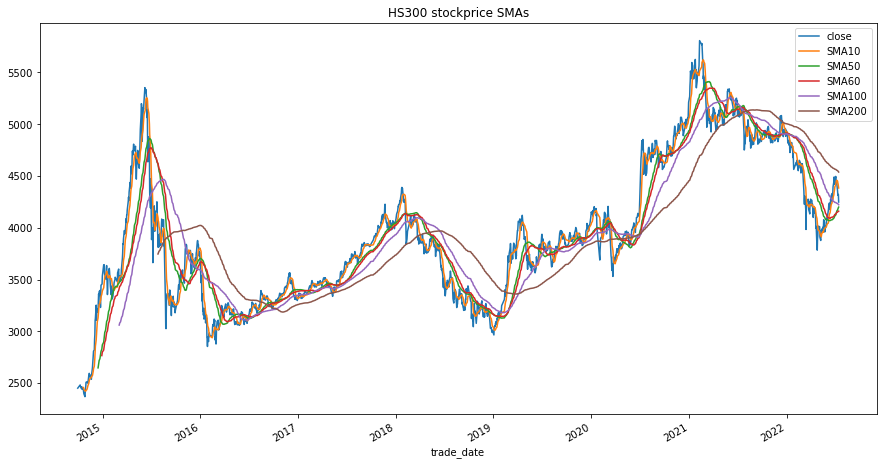

In [9]:
df_hs[['close','SMA10', 'SMA50', 'SMA60', 'SMA100', 'SMA200']].plot(figsize=(15,8), 
                                                                    title = 'HS300 stockprice SMAs')

# Step 4: Trading Strategy

## SMA version 1

In [10]:
df_hs.dropna(inplace=True)

In [11]:
df_hs['position_old'] = np.where(df_hs['SMA10'] > df_hs['SMA60'], 1, -1)

## SMA version 2

In [12]:
def SMA_pos_v2(st, lt):
    """
    Produce the positions of buy and sell
    
    Input: 
        st: short-term SMA
        lt: long-term SMA
    
    Output: the positions of buy and sell
    """
    return np.where(st - lt > 20, 1, 0) - np.where(st - lt < -20, 1, 0)

In [13]:
df_hs['position'] = SMA_pos_v2(df_hs['SMA10'], df_hs['SMA60'])

<AxesSubplot:xlabel='trade_date'>

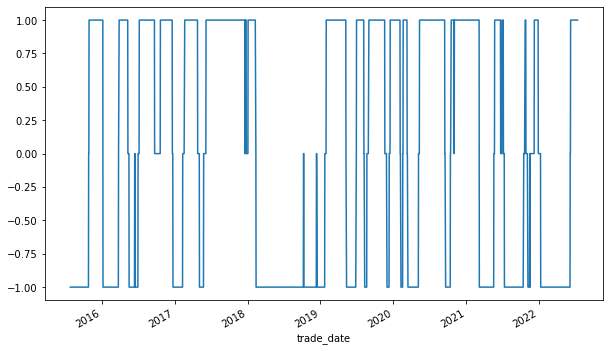

In [14]:
df_hs['position'].plot(secondary_y='Position', figsize=(10, 6))

# Step 5: Backtesting

# SMA version 1

In [15]:
# 计算大盘收益: 今日close price - 昨日close price
df_hs['returns'] = df_hs['close'] - df_hs['close'].shift(1)

In [16]:
df_hs.dropna(inplace=True)

In [17]:
# 计算策略收益
df_hs['strategy_old'] = df_hs['position_old'].shift(1) * df_hs['returns']

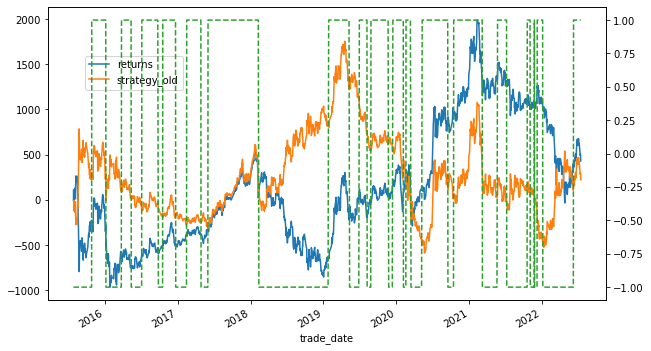

In [18]:
ax = df_hs[['returns', 'strategy_old']].cumsum().plot(figsize=(10, 6))
df_hs['position_old'].plot(ax=ax, secondary_y='position_old', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

## SMA version2

In [19]:
# 计算策略收益
df_hs['strategy'] = df_hs['position'].shift(1) * df_hs['returns']

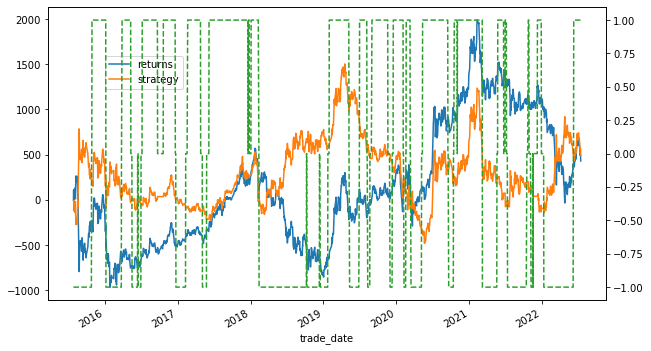

In [20]:
# cumulative sum 
ax = df_hs[['returns', 'strategy']].cumsum().plot(figsize=(10, 6))
df_hs['position'].plot(ax=ax, secondary_y='position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

In [21]:
# direct sum
df_hs[['returns', 'strategy_old', 'strategy']].sum()

returns         429.7959
strategy_old    221.3257
strategy        493.6018
dtype: float64

相比于之前简易版的SMA，更新过的版本多了一些持有股票的时间段，相对来说行为更加稳定。在简易版的SMA里，我们只有买与卖两个动作，在股票价格剧烈波动时我们买卖的频率也随之变高。换到更新的版本下，我们的模型更加沉稳了，懂得持股，以不变应万变。以沪深300为例，更新的SMA给我们带来了更高的收益。

<AxesSubplot:xlabel='trade_date'>

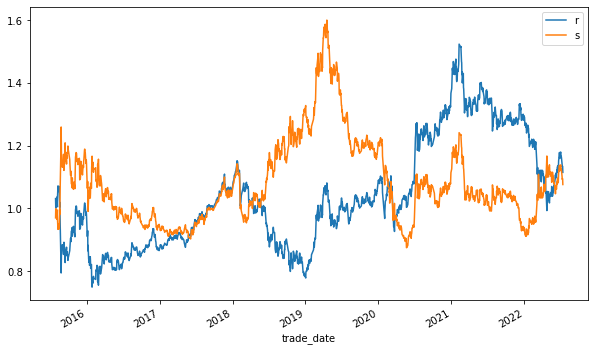

In [22]:
# old SMA, returns as rate (as comparison)
df_hs['r'] = np.log(df_hs['close'] / df_hs['close'].shift(1))
df_hs['p'] = np.where(df_hs['SMA10'] > df_hs['SMA60'], 1, -1)
df_hs['s'] = df_hs['p'].shift(1) * df_hs['r']
df_hs[['r', 's']].cumsum().apply(np.exp).plot(figsize = (10, 6))

# Task 2: Momentum Trading Strategy

## Data Preparation

In [23]:
df_hs = get_index_daily(ts_code = '000300.SH', start_date = '20140930')

In [24]:
df_hs['returns'] = df_hs['close'] - df_hs['close'].shift(1)

## Strategy

In [25]:
def momentum_pos(returns, days):
    """
    Obtain the position of momentum trading strategy
    
    input: a Series of returns, and days you want to average
    
    output: the position
    """
    return np.sign(returns.rolling(days).mean())

In [26]:
# 自身
df_hs['pos1'] = momentum_pos(df_hs['returns'], 1)
df_hs['strategy_m1'] = df_hs['pos1'].shift(1) * df_hs['returns']

In [27]:
df_hs.dropna(inplace = True)

In [28]:
# 2天
df_hs['pos2'] = momentum_pos(df_hs['returns'], 2)
df_hs['strategy_m2'] = df_hs['pos2'].shift(1) * df_hs['returns']

In [29]:
df_hs.dropna(inplace = True)

In [30]:
# 6天
df_hs['pos6'] = momentum_pos(df_hs['returns'], 6)
df_hs['strategy_m6'] = df_hs['pos6'].shift(1) * df_hs['returns']

In [31]:
df_hs.dropna(inplace = True)

## Backtesting

In [32]:
df_hs.head()

,ts_code,close,open,high,low,pre_close,change,pct_chg,vol,amount,returns,pos1,strategy_m1,pos2,strategy_m2,pos6,strategy_m6
trade_date,,,,,,,,,,,,,,,,,
2014-10-21,000300.SH,2433.391,2453.406,2459.255,2432.552,2454.711,-21.320,-0.8685,96241912.0,8.662220e+07,-21.320,-1.0,-21.320,-1.0,-21.320,-1.0,21.320
2014-10-22,000300.SH,2418.641,2434.886,2447.467,2417.562,2433.391,-14.750,-0.6062,88656193.0,8.225174e+07,-14.750,-1.0,14.750,-1.0,14.750,-1.0,14.750
2014-10-23,000300.SH,2395.936,2415.440,2424.662,2392.532,2418.641,-22.705,-0.9388,103491839.0,8.604545e+07,-22.705,-1.0,22.705,-1.0,22.705,-1.0,22.705
2014-10-24,000300.SH,2390.706,2397.848,2404.993,2385.725,2395.936,-5.230,-0.2183,74974869.0,6.560123e+07,-5.230,-1.0,5.230,-1.0,5.230,-1.0,5.230
2014-10-27,000300.SH,2368.832,2377.542,2377.542,2361.680,2390.706,-21.874,-0.9150,73862447.0,6.595648e+07,-21.874,-1.0,21.874,-1.0,21.874,-1.0,21.874


<AxesSubplot:xlabel='trade_date'>

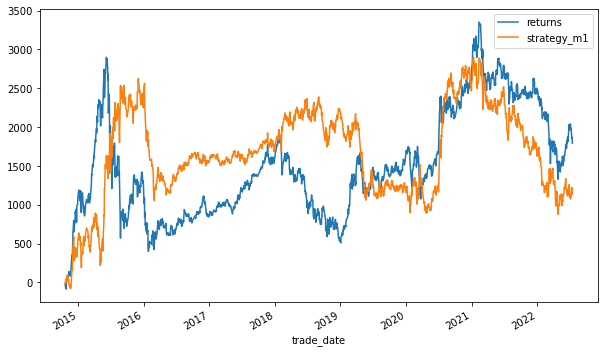

In [33]:
# 自身
df_hs[['returns', 'strategy_m1']].cumsum().plot(figsize=(10, 6))

<AxesSubplot:xlabel='trade_date'>

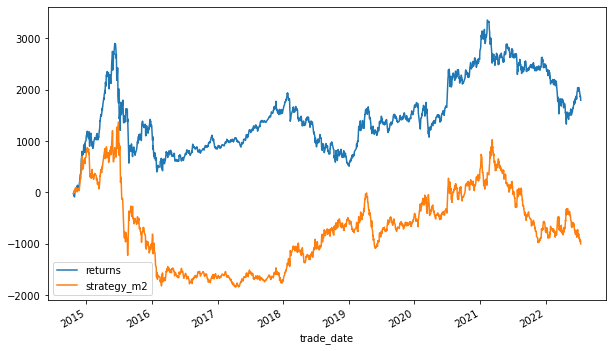

In [34]:
# 2 天
df_hs[['returns', 'strategy_m2']].cumsum().plot(figsize=(10, 6))

<AxesSubplot:xlabel='trade_date'>

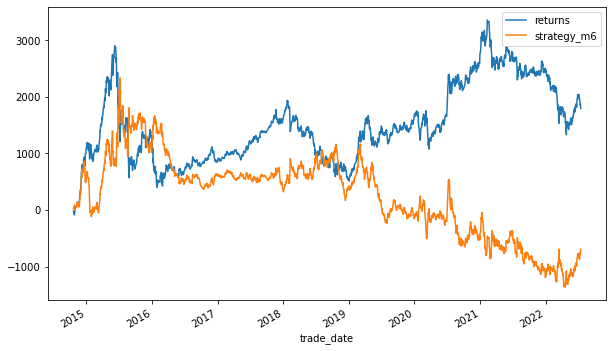

In [35]:
# 6 天
df_hs[['returns', 'strategy_m6']].cumsum().plot(figsize=(10, 6))

In [36]:
# direct sum
df_hs[['returns', 'strategy_m1', 'strategy_m2', 'strategy_m6']].sum()

returns        1793.8163
strategy_m1    1140.6495
strategy_m2   -1000.4655
strategy_m6    -690.4393
dtype: float64

## returns as rate (as comparison)

<AxesSubplot:xlabel='trade_date'>

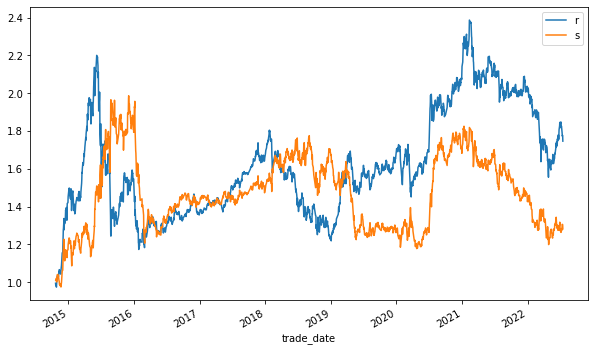

In [37]:
df_hs['r'] = np.log(df_hs['close'] / df_hs['close'].shift(1))
df_hs['p'] = np.sign(df_hs['r'].rolling(1).mean())
df_hs['s'] = df_hs['p'].shift(1) * df_hs['r']
df_hs[['r', 's']].cumsum().apply(np.exp).plot(figsize = (10, 6))

In [38]:
df_hs[['r', 's']].sum()

r    0.557287
s    0.248112
dtype: float64